In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 50

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2023-06-14 10:10:10.997541: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

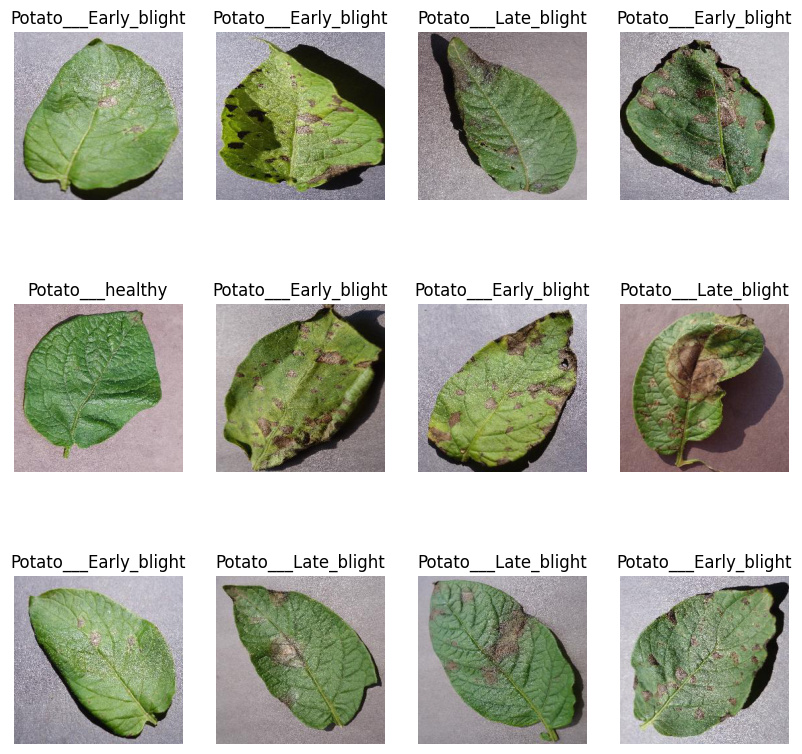

In [5]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [6]:
def get_dataset_partitions(ds, train_split = 0.8, test_split = 0.1, val_split  = 0.1, shuffle = True, shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int (train_split * ds_size)
    val_size = int (val_split *ds_size)
    train_ds= ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, test_ds, val_ds
    

In [7]:
train_ds, test_ds, val_ds = get_dataset_partitions(dataset)


In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_da = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)


In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential ([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [11]:
input_size = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation= 'relu', input_shape = input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation= 'relu', input_shape = input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation= 'relu', input_shape = input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation= 'relu', input_shape = input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation= 'relu', input_shape = input_size),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes, activation ='softmax')
])
model.build(input_shape = input_size)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    epochs = 50,
    verbose =1
)

Epoch 1/50
54/54 [==============================] - 77s 1s/step - loss: 0.8284 - accuracy: 0.5810 - val_loss: 0.6918 - val_accuracy: 0.7344
Epoch 2/50
54/54 [==============================] - 75s 1s/step - loss: 0.4282 - accuracy: 0.8316 - val_loss: 0.3693 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 73s 1s/step - loss: 0.2960 - accuracy: 0.8814 - val_loss: 0.2379 - val_accuracy: 0.9048
Epoch 4/50
54/54 [==============================] - 86s 2s/step - loss: 0.1952 - accuracy: 0.9259 - val_loss: 0.3015 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 78s 1s/step - loss: 0.1790 - accuracy: 0.9282 - val_loss: 0.2636 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 76s 1s/step - loss: 0.1645 - accuracy: 0.9369 - val_loss: 0.1345 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 77s 1s/step - loss: 0.1622 - accuracy: 0.9369 - val_loss: 0.1331 - val_accuracy: 0.9427
Epoch 8/50
54/54 [==

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


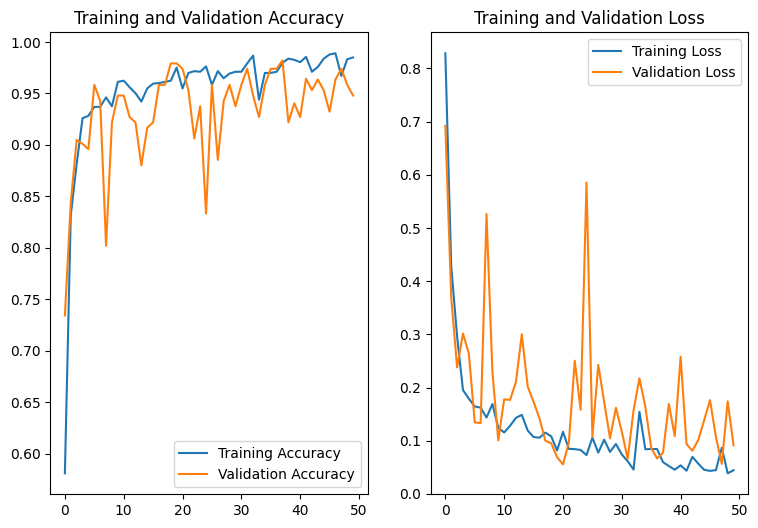

In [16]:
plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


label: Potato___Late_blight


TypeError: only integer scalar arrays can be converted to a scalar index

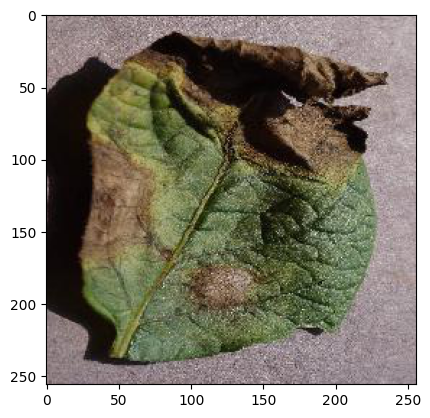

In [17]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label  = label_batch[0].numpy()
    
    plt.imshow(first_image)
    print("label:", class_names[first_label])
    prediction = model.predict(image_batch)
    print('prediction', class_names[prediction[0]])
    